#                                 Projeto 2- Ciência dos Dados


##### Como os índices de suicídio são afetados por Índice de Desenvolvimento Humano, PIB ber Capita, sexo, geração, idade e país
Maria Victória Cavalieri e Laura Perim

## 1- Importando e limpando os dados
Ness etapa, importamos a base de dados obtida no Kaggle, e a limpamos para podermos analisá-la com grau elevado de autonomia.

In [1]:
%matplotlib notebook
%reset -f
from sklearn.model_selection import train_test_split
from scipy import stats
import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
 #Abrindo o documento e renomeando as colunas de alguns elementos das colunas
dados= pd.read_csv('suicide_.csv')
dados.rename(columns={'gdp_per_capita ($)':'gdp_capita'}, inplace=True)
dados.rename(columns={'HDI for year':'HDI'}, inplace=True)
dados.rename(columns={'suicides/100k pop' :'suicides_100k_pop'}, inplace=True)
dados.head()

,country,year,sex,age,suicides_no,population,suicides_100k_pop,country-year,HDI,gdp_for_year ($),gdp_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [3]:
def regress(X,Y):
    '''
    X: coluna(s) do DataFrame que serão utilizadas como variável(is) preditoras/explicativas (independente(s))
    Y: coluna do DataFrame que será utilizada como variável resposta (dependente)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results
df = dados[[ 'year', 'sex', 'age','suicides_100k_pop', 'population','HDI',
'gdp_capita','generation']].dropna()


In [4]:
df.describe()

,year,suicides_100k_pop,population,HDI,gdp_capita
count,8364.000000,8364.000000,8.364000e+03,8364.000000,8364.000000
mean,2005.348637,11.991936,1.852173e+06,0.776601,21074.371593
std,8.803020,17.361772,3.969754e+06,0.093367,22579.186968
min,1985.000000,0.000000,8.750000e+02,0.483000,313.000000
25%,2000.000000,1.040000,1.216425e+05,0.713000,4862.000000
50%,2010.000000,5.720000,4.722505e+05,0.779000,12584.000000
75%,2012.000000,15.442500,1.500290e+06,0.855000,30271.000000
max,2014.000000,187.060000,4.350934e+07,0.944000,126352.000000


## 2- Preparando os dados para análise
Aqui, tivemos que substituir palavras ( variáveis qualitativas) por binários, como 1= homem e 0=mulher. Isso será feito mais pra frente com os países e com as faixa etárias, que se tornarão variáveis denominadas "dummies". Basicamente elas também se tornam variáveis binárias, mas como há mais de uma categoria, só uma torna-se 1, enquanto todo o resto se torna 0 a cada linha.

In [5]:
#Separando os sexos masculinos e femininos para a análise de dados, e os nomeando com variáveis binárias para utilizar a função de regressão
df.loc[df.sex == 'male', 'sex'] = 1
df.loc[df.sex == 'female', 'sex'] = 0
df.sex = df.sex.astype('int')
df.head()

,year,sex,age,suicides_100k_pop,population,HDI,gdp_capita,generation
72,1995,1,25-34 years,5.58,232900,0.619,835,Generation X
73,1995,1,55-74 years,5.06,178000,0.619,835,Silent
74,1995,0,75+ years,4.90,40800,0.619,835,G.I. Generation
75,1995,0,15-24 years,4.59,283500,0.619,835,Generation X
76,1995,1,15-24 years,4.56,241200,0.619,835,Generation X


## 3- Análise descritiva
Vamos começar fazendo algumas análises básicas dos dados como correlação entre elas ( se a correlação for muito alta, isso pode atrapalhar na análise de regressão, por exemplo).

In [6]:
#Calculando a covariância entre anguns dados da tabela,  e calculando a média entre as faixas etárias 
df2= df[['suicides_100k_pop', 'population','HDI',
'gdp_capita']]
df2.corr()


,suicides_100k_pop,population,HDI,gdp_capita
suicides_100k_pop,1.000000,-0.023197,0.074279,-0.002339
population,-0.023197,1.000000,0.102943,0.073701
HDI,0.074279,0.102943,1.000000,0.771228
gdp_capita,-0.002339,0.073701,0.771228,1.000000


Apesar de algumas correlações serem razoavelmente altas, como HDI (Índice de desenvolvimento humano) e GDP ( PIB per capita), 
vamos considerar todas as variáveis como possíveis influentes em nossa análise. Definimos que se a correlção superasse 0,8, ela seria
desconsiderada da análise, mas não houve nenhum caso assim.

Agora, vamos analisar como a média da taxa de suicídios se distribui para cada faixa etária. Para isso, plotaremos um histograma
que combina essa média com cada idade representada.

<IPython.core.display.Javascript object>


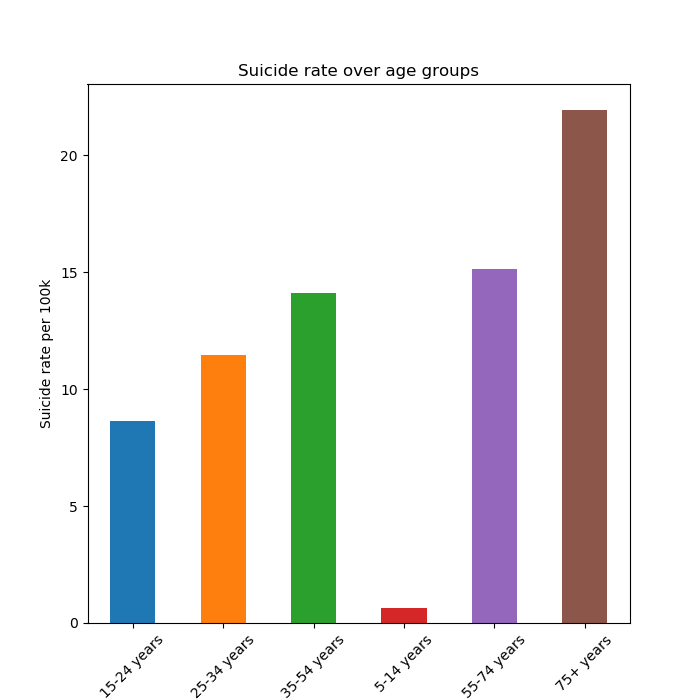

age
15-24 years     8.651736
25-34 years    11.467518
35-54 years    14.116133
5-14 years      0.628623
55-74 years    15.143006
75+ years      21.944598
Name: suicides_100k_pop, dtype: float64


sex
0     4.937198
1    19.046674
Name: suicides_100k_pop, dtype: float64

In [7]:

media= df.suicides_100k_pop.groupby(by=df.age).mean()
plt.figure(figsize=(7,7))
media.plot.bar(rot=45)
plt.xlabel("Years",fontsize=10)
plt.ylabel("Suicide rate per 100k")
plt.title('Suicide rate over age groups')
plt.show()

print(media)
df.suicides_100k_pop.groupby(by=df.sex).mean()

Podemos observar que a menor taxa se encontra entre crianças de 5-14 anos, e que a maior encontrasse na faixa de 75+ anos. Também podemos observar que as faixas de 35-54
e 55-74 anos são bem próximas.

#### Analisando os dados das  diferentes faixas etárias

In [8]:
f1=df.suicides_100k_pop[df.age=="5-14 years"].describe()
f2=df.suicides_100k_pop[df.age=="15-24 years"].describe()
f3=df.suicides_100k_pop[df.age=="25-34 years"].describe()
f4=df.suicides_100k_pop[df.age=="35-54 years"].describe()
f5=df.suicides_100k_pop[df.age=="55-74 years"].describe()
f6=df.suicides_100k_pop[df.age=="75+ years"].describe()

### Plotando um histograma para analisar a média por país
Agora vamos analisar como a taxa média de suicídios se distribui para cada país.

<IPython.core.display.Javascript object>


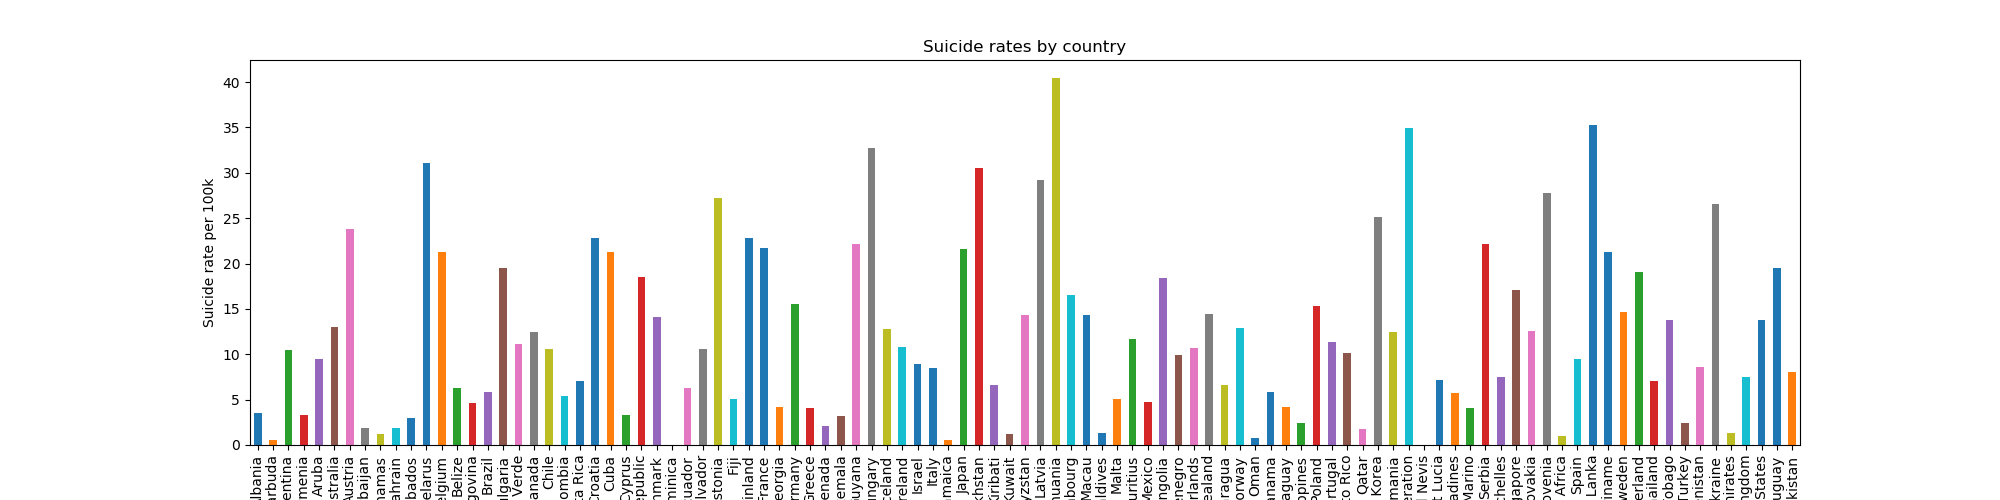

In [9]:
df_pais = dados[[ 'country','year', 'sex', 'age','suicides_100k_pop', 'population','HDI',
'gdp_capita','generation']]
mediaporpais=country_relevance= df_pais.suicides_100k_pop.groupby(by=df_pais.country).mean()
plt.figure(figsize=(20,5))
mediaporpais.plot.bar()
plt.xlabel('Country')
plt.ylabel("Suicide rate per 100k")
plt.title("Suicide rates by country")
plt.show()

Agora vamos analisar como a taxa de suicídios varia de acordo com o ano, desde 10985 até 2016:

<IPython.core.display.Javascript object>


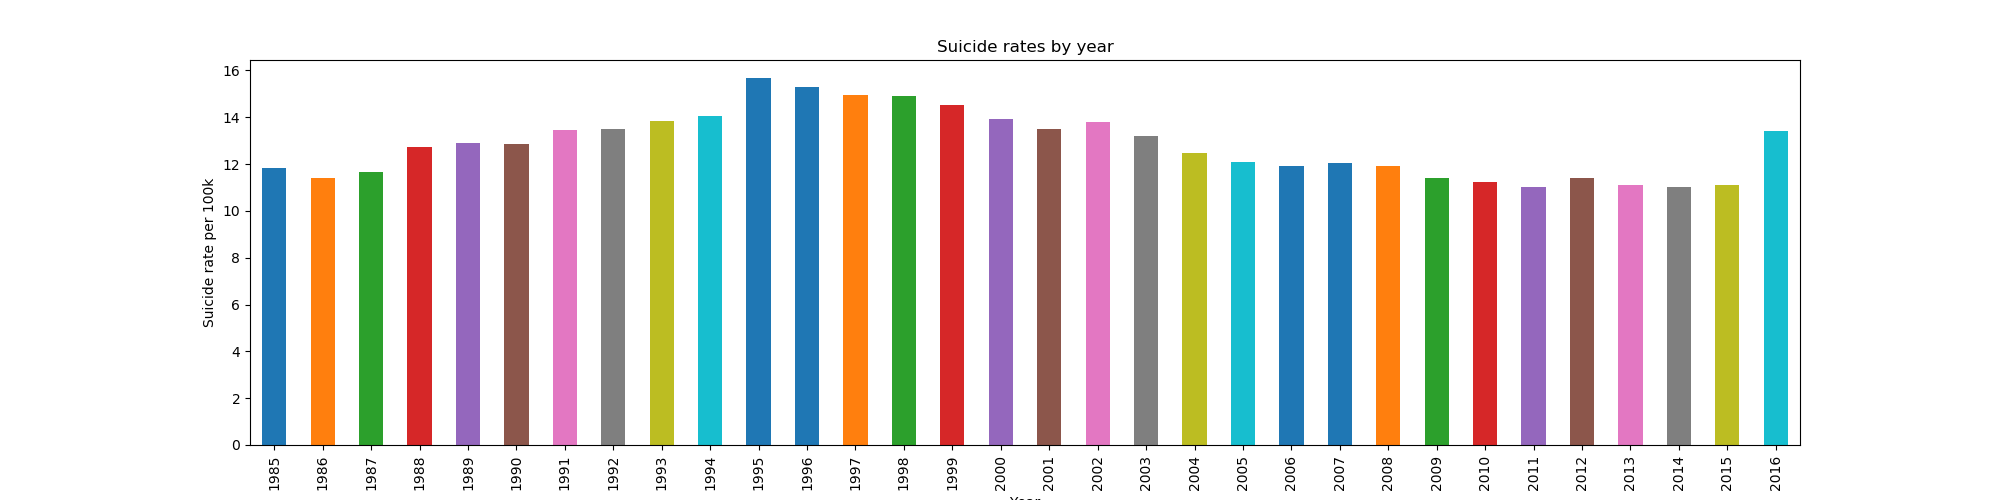

In [10]:
df_ano = dados[[ 'country','year', 'sex', 'age','suicides_100k_pop', 'population','HDI',
'gdp_capita','generation']]
mediaporano= df_ano.suicides_100k_pop.groupby(by=df_ano.year).mean()
plt.figure(figsize=(20,5))
mediaporano.plot.bar()
plt.xlabel('Year')
plt.ylabel("Suicide rate per 100k")
plt.title("Suicide rates by year")
plt.show()

<IPython.core.display.Javascript object>


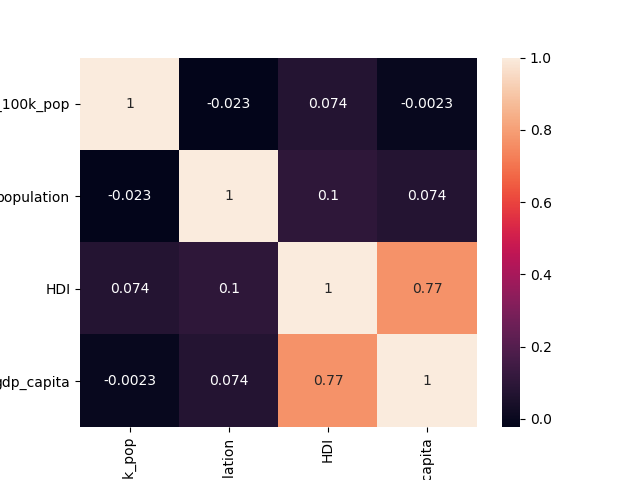

In [12]:
import seaborn

plt.figure()
seaborn.heatmap(df2.corr(), annot=True)
plt.show()

## 4- Análise por Regressão Linear

Vamos começar a analisar nosso modelo por meio de Regressão Linear. Vamos usar o modelo pronto do Python, mas como possuímos variáveis literais (qualitativas), teremo que transformá-las em "Dummies" Além disso, vamos dividir nosso database em treinamento e teste, para verificar a eficácia de nosso modelo posteriormente.

In [13]:
X = df[[ 'sex', 'year', 'population','HDI',
'gdp_capita']]
X = X.join(pd.get_dummies(df['age']))
X = X.join(pd.get_dummies(df['generation']))
Y = df['suicides_100k_pop']

X_train, X_test, y_train, y_test = train_test_split(
X, Y, test_size=0.33, random_state=42)
results = regress(X_train,y_train)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      suicides_100k_pop   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     187.4
Date:                Tue, 02 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:56:49   Log-Likelihood:                -22733.
No. Observations:                5603   AIC:                         4.550e+04
Df Residuals:                    5587   BIC:                         4.560e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             351.3461     78.367      4.483      0.000     197.717     504.975
sex                14.0193      0.375     37.427      0.000      13.285      14.754
year               -0.2459      0.052     -4.703      0.000      -0.348      -0.143
population      -6.475e-08   4.87e-08     -1.330      0.184    -1.6e-07    3.07e-08
HDI                41.9307      3.271     12.820      0.000      35.519      48.343
gdp_capita         -0.0001   1.33e-05     -8.543      0.000      -0.000   -8.75e-05
15-24 years        55.0835     12.429      4.432      0.000      30.718      79.449
25-34 years        58.0441     12.652      4.588      0.000      33.240      82.848
35-54 years        61.2293     13.209      4.635      0.000      35.334      87.124
5-14 years         45.0859     11.967      3.767      0.000      21.626      68.546
55-74 years        62.9450     13.904      4.527      0.000      35.687      90.203
75+ years          68.9584     14.302      4.822      0.000      40.921      96.995
Boomers            57.1011     12.738      4.483      0.000      32.129      82.073
G.I. Generation    60.0247     11.425      5.254      0.000      37.627      82.423
Generation X       57.9557     13.384      4.330      0.000      31.718      84.193
Generation Z       61.4361     14.653      4.193      0.000      32.710      90.162
Millenials         58.7499     14.051      4.181      0.000      31.205      86.295
Silent             56.0786     12.236      4.583      0.000      32.092      80.065
==============================================================================
Omnibus:                     3126.243   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35341.617
Skew:                           2.457   Prob(JB):                         0.00
Kurtosis:                      14.280   Cond. No.                     5.94e+22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.99e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Como podemos observar, os índices que indicam a probabilidade dos resíudos seguirem uma normal (Prob JB e Prob Omnibus), são inferiores a alfa, o que provavelmente significa que os erros são distantes de uma normal. Com isso, concluímos que o modelo de Regressão Linear não seria o melhor para modelar essa situação, já que ele assume que os erros seguem uma distribuição próxima a uma Normal.
Para ter certeza, vamos plotar um gráficos dos resíduos e compará-los com o comportamento normal:

<IPython.core.display.Javascript object>


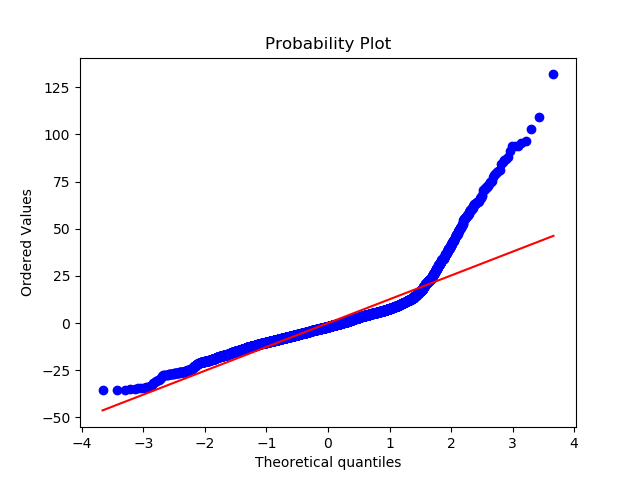

In [18]:

plt.figure()
erros=results.resid
stats.probplot(erros,dist='norm',plot=plt)
plt.show()

O gráfico acima confirma que os erros não seguem um comportamento normal, principalmente conforme aumentam. Isso significa que nosso modelo provavelmente não predirá de forma precisa o Índice de Suicídios. Vamos confirmar nossa hipótese usando nossa base de testes:

In [15]:
from sklearn.metrics import mean_squared_error
results_teste = regress(X_test,y_test)
y_pred= results_teste.predict(sm.add_constant(X_test))
erro=mean_squared_error(y_test,y_pred)
print(erro)


208.75099730214632


Vamos comparar nosso erro com o erro se considerarmos também a base de dados que utilizamos para treinar nosso modelo:

In [23]:
y_pred= results_teste.predict(sm.add_constant(X_train))
erro=mean_squared_error(y_train,y_pred)
print(erro)

196.60646626886785


## 5- Modelo de Regressão Random Forest

Agora vamos utilizar outro modelo de Regressão denominado Random Forest, e ver como o erro deste se compara ao anterior:

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor 
  
 # create regressor object 
regressor = RandomForestRegressor(n_estimators = 200, random_state = 0) 
# fit the regressor with x and y data 
regressor.fit(X_train, y_train)   
y_pred= regressor.predict(X_test)
erro=mean_squared_error(y_test,y_pred)
print(erro)

89.57007397661356


Podemos observar que esse erro é bem menor que o anterior dado pela regressão linear, o que significa que ele é mais eficaz nesse caso.

Vamos comparar nosso erro com o erro se considerarmos também a base de dados que utilizamos para treinar nosso modelo:

In [22]:
   
y_pred= regressor.predict(X_train)
erro=mean_squared_error(y_train,y_pred)
print(erro)

12.574727275978493


O erro diminui bastante ao fazermos isso, uma vez que a base inclui também os dados utilizados para ensinar o modelo a avaliar as variáveis